# Practice Lab - 应用机器学习的建议
在这个实验室中，您将探索评估和改进机器学习模型的技术。

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [35]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - 评估学习算法（多项式回归）

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> 设您已经创建了一个机器学习模型，并且您发现它非常适合您的训练数据。您就完成了吗？并不完全是。创建模型的目的是为了能够预测新示例的值。

在部署模型之前，如何测试模型在新数据上的性能呢？ 
答案有两个部分：
* 将原始数据集拆分为“训练”和“测试”集。
    * 使用训练数据来拟合模型的参数
    * 使用测试数据来评估模型在新数据上的表现
* 开发一个误差函数来评估您的模型。

<a name="2.1"></a>
### 2.1 拆分数据集
课程建议保留20-40％的数据集进行测试。让我们使用一个sklearn函数 [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 来执行拆分。运行以下单元格后，请再次检查形状。

In [36]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 绘制训练和测试集
您可以看到下面的数据点将成为训练（红色）部分，与未经训练的模型的部分（测试）混合在一起。此特定数据集是添加了噪声的二次函数。为了参考，显示了“理想”曲线。

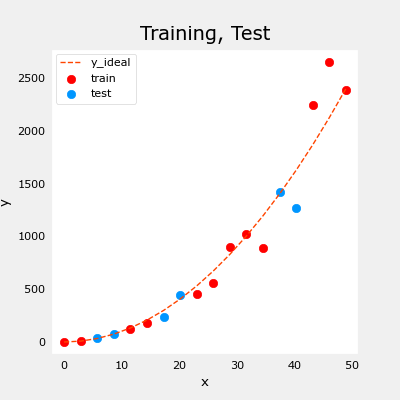

In [37]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 线性回归的误差计算，用于模型评估
当评估一个线性回归模型时，您需要计算预测值和目标值之间的平均平方误差差异。

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1


下面，创建一个函数来评估线性回归模型的数据集上的误差。

In [38]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
      err += (yhat[i] - y[i])**2
    err =(1/2)* err/m
    ### END CODE HERE ### 
    
    return(err)

In [39]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse111(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    err = np.sum((yhat-y)**2)/(2*m)
    ### END CODE HERE ### 
    
    return(err)

In [40]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 比较训练和测试数据的性能
让我们构建一个高次多项式模型来最小化训练误差。这将使用sklearn中的线性回归函数。如果您想查看详细信息，则代码在导入的实用文件中。以下是步骤：
* 创建并拟合模型。（“fit”是训练或运行梯度下降的另一个名称）。
* 计算训练数据上的误差。
* 计算测试数据上的误差。

In [41]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

在训练集上计算的误差明显小于测试集。

In [42]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01



下面的图表说明了这一点。模型在训练数据上拟合得非常好。为了做到这一点，它创建了一个复杂的函数。测试数据不是训练的一部分，模型在这些数据上的预测效果很差。

这种模型描述为：1）过度拟合，2）方差高，3）泛化能力差。

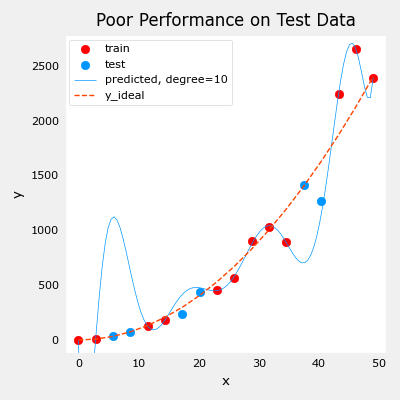

In [43]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

测试集上的误差表明该模型在新数据上的表现不佳。如果您使用测试误差来指导改进模型，则该模型将在测试数据上表现良好…但是测试数据意味着代表新数据。
您需要另一个数据集来测试新数据的性能。

在讲座期间提出的建议是将数据分为三组。下表中显示的训练、交叉验证和测试集的分布是典型的分布，但可以根据可用数据量进行变化。

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


让我们生成以下三个数据集。我们将再次使用sklearn中的train_test_split，但会调用两次以获取三个拆分：

In [44]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 

如上所述，多项式模型的次数过高。如何选择一个好的值？事实证明，如图所示，训练和交叉验证性能可以提供指导。通过尝试一系列次数值，可以评估训练和交叉验证性能。随着次数变得过大，交叉验证性能相对于训练性能将开始下降。让我们在我们的示例中尝试这个方法。

<a name="3.1"></a>
### 3.1 绘制训练、交叉验证、测试集
如下所示，将成为训练数据点（红色）的数据点与模型未经过训练的数据点（测试集和交叉验证集）混合在一起。

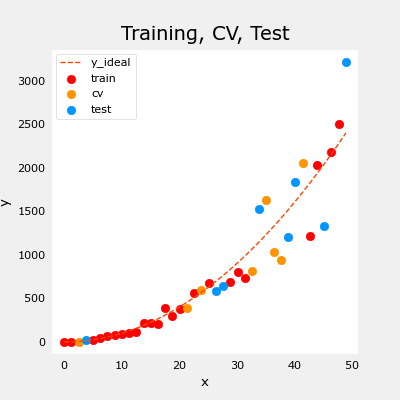

In [45]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 寻找最优次数
在以前的实验中，您发现可以通过利用多项式（参见Course1，Week2特征工程和多项式回归实验）创建能够拟合复杂曲线的模型。此外，您还证明了通过增加多项式的次数，可以创建过度拟合的情况（参见Course1，Week3过度拟合实验）。让我们在这里利用这些知识来测试我们识别过拟合和欠拟合的能力。

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [46]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

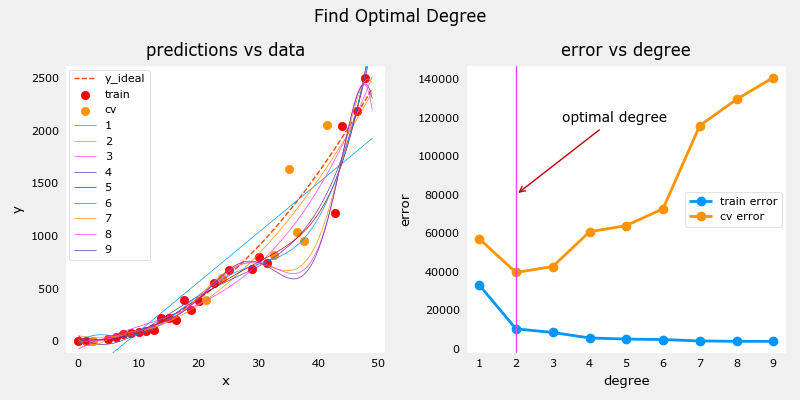

In [47]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)


上面的图表演示了将数据分成两组，即模型经过训练的数据和模型未经过训练的数据，可用于确定模型是欠拟合还是过拟合。在我们的示例中，我们通过增加使用的多项式的次数来创建了各种从欠拟合到过拟合的模型
- 在左图中，实线表示这些模型的预测情况。次数为1的多项式模型生成一条直线，与很少的数据点相交，而最大的次数非常接近每个数据点。
- 在右图中：
    - 训练数据的误差（蓝色）随着模型复杂度的增加而降低，符合预期。
    - 交叉验证数据的误差最初随着模型开始符合数据而降低，但随后随着模型开始过度拟合训练数据（未能 泛化 ）而增加。  
    
值得注意的是，这些示例中的曲线不像演示用的曲线那样平滑。显然，分配给每个组的具体数据点可以显著改变结果。重要的是要理解其一般趋势。

<a name="3.3"></a>
### 3.3 整正则化
在之前的实验中，您已经使用了正则化来减少过度拟合。与次数类似，可以使用相同的方法来调整正则化参数lambda ($\lambda$)。

让我们通过从高次多项式开始并变化正则化参数来演示这一点。

In [48]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

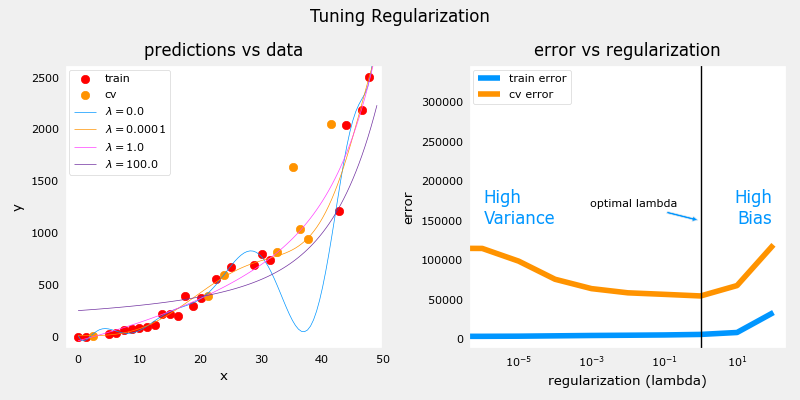

In [49]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

上面的图表显示，随着正则化的增加，模型从高方差（过拟合）模型移动到高偏差（欠拟合）模型。右侧图中的垂直线显示了lambda的最佳值。在这个例子中，多项式次数设置为10。

<a name="3.4"></a>
### 3.4 获取更多数据：增加训练集大小（m）
当模型过度拟合（高方差）时，收集更多数据可以提高性能。让我们在这里尝试一下。

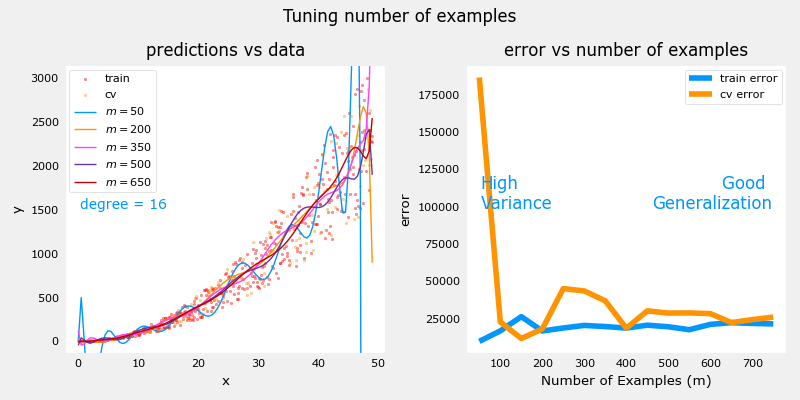

In [50]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

上面的图表显示，当模型具有高方差并过度拟合时，添加更多示例可以提高性能。请注意左图上的曲线。具有最高$m$值的最终曲线是位于数据中心的平滑曲线。在右侧，随着示例数量的增加，训练集和交叉验证集的性能趋于类似的值。请注意，曲线不像在讲座中看到的那么平滑。这是可以预期的。趋势仍然清晰：更多的数据可以提高泛化性能。

> 请注意，当模型存在高偏差（欠拟合）时，添加更多示例不会提高性能。


<a name="4"></a>
## 4 - 评估学习算法（神经网络）
以上，您调整了多项式回归模型的各个方面。在这里，您将使用神经网络模型。让我们首先创建一个分类数据集。

<a name="4.1"></a>
### 4.1 Data Set
请运行下面的单元格以生成数据集并将其拆分为训练集，交叉验证（CV）集和测试集。在这个例子中，我们增加了交叉验证数据点的百分比以强调。

In [51]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


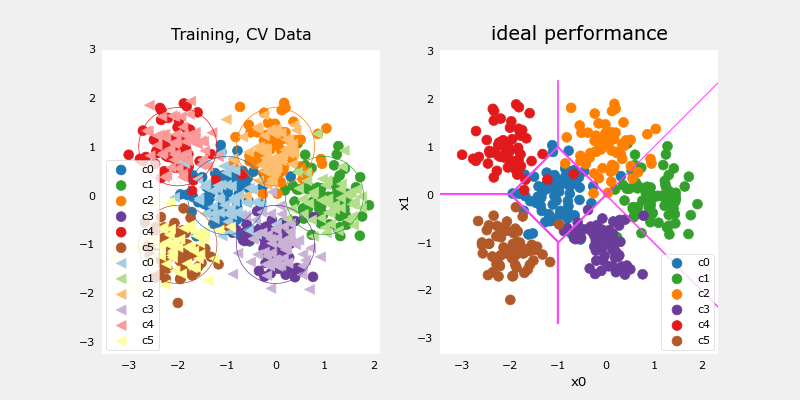

In [52]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

上面，您可以在左侧看到数据。颜色标识了六个集群。显示了训练点（点）和交叉验证点（三角形）。有趣的点是那些落在模糊位置的点，其中任何一个集群都可能将它们视为成员。您对神经网络模型有什么期望？过度拟合的例子是什么？欠拟合的例子是什么？

对于这个数据集，我们期望神经网络模型能够学习将数据点正确分类的决策边界。如果模型过度拟合，它可能会过于依赖训练数据，从而导致在新数据上表现不佳。例如，模型可能会在训练数据上表现非常好，但在交叉验证或测试数据上表现较差。过度拟合的另一个例子是，模型可能会在训练数据中学习记住“噪声”，从而导致在新数据上表现不佳。

相反，如果模型欠拟合，它可能无法捕获数据中的复杂性，从而导致在训练和测试数据上都表现不佳。例如，如果模型过于简单，则可能无法捕获数据中的非线性关系，从而表现不佳。另一方面，如果模型太复杂，则可能无法泛化到新数据。

在右侧的图例中，我们可以看到一个“理想”的模型，其中等距边界将每个集群分开。这个模型的缺点是，它在整个数据集中都会“误分类”约8%的数据点。

<a name="4.2"></a>
### 4.2 用计算分类错误率来评估分类模型
这里使用的分类模型评估函数仅为不正确预测的比例：
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

请完成计算分类错误的例程。请注意，在本实验室中，目标值是类别的索引，而不是进行独热编码。 [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [53]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if y[i] != yhat[i]:
            incorrect +=1
    cerr = incorrect/m
    ### END CODE HERE ### 
    
    return(cerr)

In [54]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - 模型复杂度
下面，您将构建两个模型。一个是复杂模型，一个是简单模型。您将评估模型以确定它们是否可能出现过拟合或欠拟合。

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
请构建一个三层模型：
* 具有120个单元的密集层，relu激活
* 具有40个单元的密集层，relu激活
* 具有6个单元的密集层和线性激活（不是softmax）
使用以下编译：
* 使用S`parseCategoricalCrossentropy`损失函数，记得使用`from_logits=True`
* Adam优化器，学习率为0.01。

In [55]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation='relu',name="l1"),
        tf.keras.layers.Dense(40, activation='relu',name="l2"),
        tf.keras.layers.Dense(6, activation='linear',name="l3")
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),

    ### END CODE HERE ### 
)

In [56]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0404
Epoch 2/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4354
Epoch 3/1000
13/13 [==============================] - 0s 916us/step - loss: 0.3408
Epoch 4/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3128
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2791
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2805
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2461
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2239
Epoch 9/1000
13/13 [==============================] - 0s 997us/step - loss: 0.2225
Epoch 10/1000
13/13 [==============================] - 0s 916us/step - loss: 0.2054
Epoch 11/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2172
Epoch 12/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2076
Epoch 13

In [57]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 120)               360       
                                                                 
 l2 (Dense)                  (None, 40)                4840      
                                                                 
 l3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 1s 587us/step


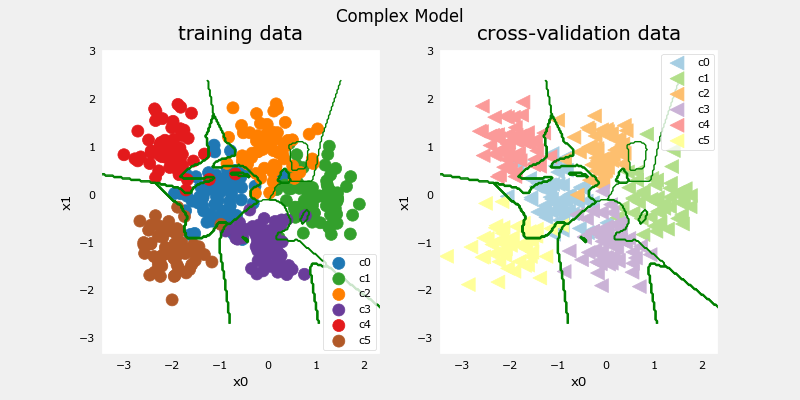

In [58]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

训练这个模型已经非常努力地捕捉每个类别的异常值。因此，它将一些交叉验证数据分类错误了。让我们计算分类错误。

In [59]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 776us/step
categorization error, training, complex model: 0.013
categorization error, cv,       complex model: 0.116


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* 具有6个单元的密集层，relu激活
* 具有6个单元的密集层和线性激活
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [60]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
      
        tf.keras.layers.Dense(6, activation='relu',name="l1"),
        tf.keras.layers.Dense(6, activation='linear',name="l2")
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [61]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 997us/step - loss: 1.8580
Epoch 2/1000
13/13 [==============================] - 0s 917us/step - loss: 1.6306
Epoch 3/1000
13/13 [==============================] - 0s 833us/step - loss: 1.4728
Epoch 4/1000
13/13 [==============================] - 0s 833us/step - loss: 1.3058
Epoch 5/1000
13/13 [==============================] - 0s 833us/step - loss: 1.1298
Epoch 6/1000
13/13 [==============================] - 0s 833us/step - loss: 0.9457
Epoch 7/1000
13/13 [==============================] - 0s 833us/step - loss: 0.7968
Epoch 8/1000
13/13 [==============================] - 0s 833us/step - loss: 0.6830
Epoch 9/1000
13/13 [==============================] - 0s 833us/step - loss: 0.6007
Epoch 10/1000
13/13 [==============================] - 0s 833us/step - loss: 0.5404
Epoch 11/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4912
Epoch 12/1000
13/13 [==============================] - 0s 833us/step - loss: 0.4504
E

In [62]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 6)                 18        
                                                                 
 l2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 574us/step


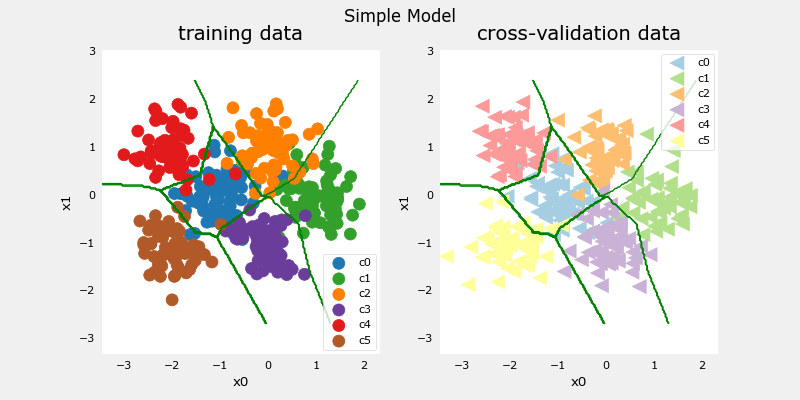

In [63]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [64]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 778us/step
categorization error, training, simple model, 0.062, complex model: 0.013
categorization error, cv,       simple model, 0.072, complex model: 0.116


我们的简单模型在训练数据上有稍高的分类错误率，但在交叉验证数据上表现比复杂模型更好。

<a name="6"></a>
## 6 - 正则化
与多项式回归的情况类似，可以应用正则化来减轻更复杂模型的影响。让我们尝试如下。

<a name="ex05"></a>
### Exercise 5


请重建您的复杂模型，但这次包括正则化。以下是一个三层模型：
* 具有120个单元的密集层，relu激活，kernel_regularizer=tf.keras.regularizers.l2(0.1)
* 具有40个单元的密集层，relu激活，kernel_regularizer=tf.keras.regularizers.l2(0.1)
* 具有6个单元的密集层和线性激活
* 使用以下编译：
* 使用SparseCategoricalCrossentropy损失函数，记得使用from_logits=True
Adam优化器，学习率为0.01。

In [65]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        
        tf.keras.layers.Dense(120, activation='relu',name="l1",kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation='relu',name="l2",kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation='linear',name="l3")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [66]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 4.4643
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.6884
Epoch 3/1000
13/13 [==============================] - 0s 1000us/step - loss: 1.3310
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0683
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9895
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9642
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9314
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8822
Epoch 9/1000
13/13 [==============================] - 0s 917us/step - loss: 0.8040
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7714
Epoch 11/1000
13/13 [==============================] - 0s 999us/step - loss: 0.7601
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7523
Epoch 13/1000
13/1

In [67]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 120)               360       
                                                                 
 l2 (Dense)                  (None, 40)                4840      
                                                                 
 l3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 612us/step


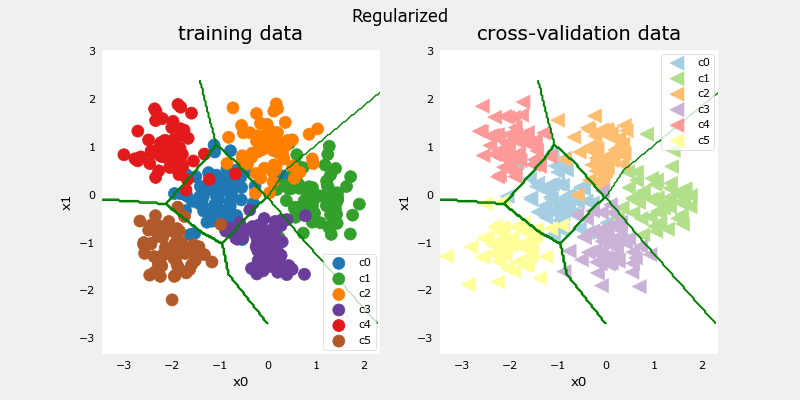

In [68]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [69]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 1ms/step
categorization error, training, regularized: 0.083, simple model, 0.062, complex model: 0.013
categorization error, cv,       regularized: 0.069, simple model, 0.072, complex model: 0.116


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - 迭代以找到最佳的正则化值

7 - 迭代以找到最佳的正则化值
就像您在线性回归中所做的那样，可以尝试许多正则化值。此代码运行需要几分钟。如果您有时间，可以运行它并检查结果。如果没有，您已经完成了作业的评分部分！

In [70]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9113
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4304
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3532
Epoch 4/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3146
Epoch 5/1000
13/13 [==============================] - 0s 998us/step - loss: 0.2783
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2669
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2406
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2248
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2239
Epoch 10/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2014
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2195
Epoch 12/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2075
Epoch 13/1000


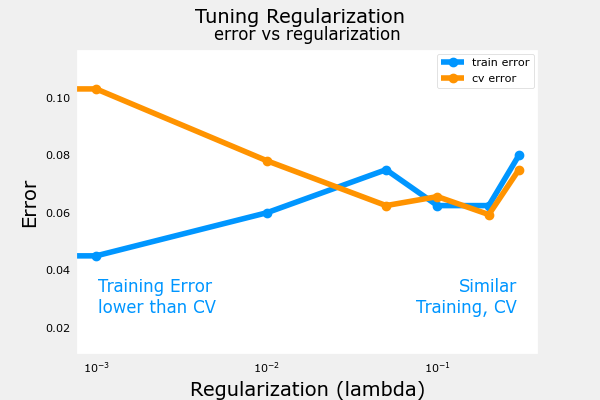

In [71]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)


随着正则化的增加，模型在训练和交叉验证数据集上的性能会收敛。对于这个数据集和模型，λ > 0.01似乎是一个合理的选择。

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 1ms/step


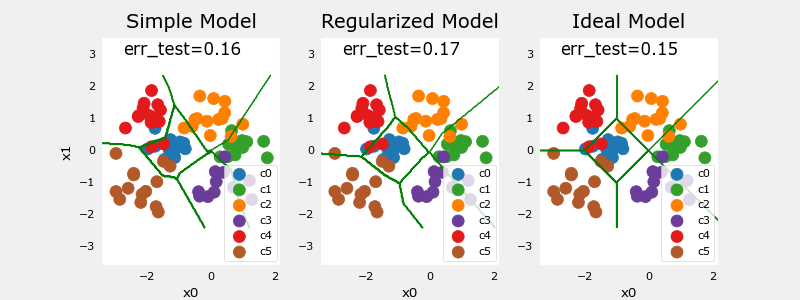

In [72]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)